# Week-6 homework notebook

# Download Dataset

In [1]:
!wget https://raw.githubusercontent.com/alexeygrigorev/datasets/master/housing.csv -O ../data/06_data_homework.csv

--2022-10-17 16:54:15--  https://raw.githubusercontent.com/alexeygrigorev/datasets/master/housing.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1423529 (1.4M) [text/plain]
Saving to: ‘../data/06_data_homework.csv’

../data/06_data_hom 100%[===================>]   1.36M  --.-KB/s    in 0.07s   

2022-10-17 16:54:15 (19.0 MB/s) - ‘../data/06_data_homework.csv’ saved [1423529/1423529]



In [4]:
!head ../data/06_data_homework.csv

longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY
-122.25,37.85,52.0,919.0,213.0,413.0,193.0,4.0368,269700.0,NEAR BAY
-122.25,37.84,52.0,2535.0,489.0,1094.0,514.0,3.6591,299200.0,NEAR BAY
-122.25,37.84,52.0,3104.0,687.0,1157.0,647.0,3.12,241400.0,NEAR BAY
-122.26,37.84,42.0,2555.0,665.0,1206.0,595.0,2.0804,226700.0,NEAR BAY


***

# Import modules

In [195]:
import pandas as pd
import numpy as np 

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [196]:
import sys 
sys.path.append('../src/')

import utilities as utils

In [197]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.feature_extraction import DictVectorizer
from sklearn.metrics import mean_squared_error
from sklearn.tree import export_text
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb

from IPython.display import display, Image
import graphviz

***

# Load Data

In [206]:
list_features = ['latitude', 'longitude', 'housing_median_age', 
                 'total_rooms', 'total_bedrooms', 'population',
                 'households', 'median_income', 'median_house_value', 'ocean_proximity']

df = pd.read_csv('../data/06_data_homework.csv', usecols=list_features)
df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [207]:
df.ocean_proximity.value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

In [209]:
df.ocean_proximity = df.ocean_proximity.str.replace('<1H OCEAN','1H OCEAN')
df.ocean_proximity = df.ocean_proximity.str.replace(' ','_')

In [210]:
df.ocean_proximity.value_counts()

1H_OCEAN      9136
INLAND        6551
NEAR_OCEAN    2658
NEAR_BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

In [211]:
df.dtypes

longitude             float64
latitude              float64
housing_median_age    float64
total_rooms           float64
total_bedrooms        float64
population            float64
households            float64
median_income         float64
median_house_value    float64
ocean_proximity        object
dtype: object

In [212]:
df.isnull().sum()

longitude               0
latitude                0
housing_median_age      0
total_rooms             0
total_bedrooms        207
population              0
households              0
median_income           0
median_house_value      0
ocean_proximity         0
dtype: int64

In [213]:
# Fill NAs with 0
df.total_bedrooms = df.total_bedrooms.fillna(0.0)
df.isnull().sum()

longitude             0
latitude              0
housing_median_age    0
total_rooms           0
total_bedrooms        0
population            0
households            0
median_income         0
median_house_value    0
ocean_proximity       0
dtype: int64

In [214]:
# Stas on medina house value
df.median_house_value.describe()

count     20640.000000
mean     206855.816909
std      115395.615874
min       14999.000000
25%      119600.000000
50%      179700.000000
75%      264725.000000
max      500001.000000
Name: median_house_value, dtype: float64

<AxesSubplot:xlabel='median_house_value', ylabel='Count'>

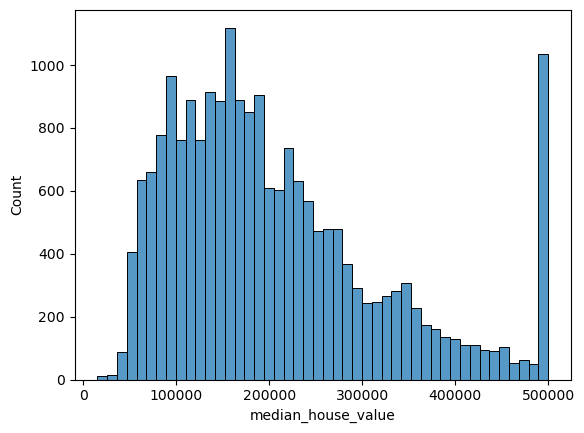

In [215]:
# plot hist of median house value
sns.histplot(df.median_house_value)

<AxesSubplot:xlabel='median_house_value', ylabel='Count'>

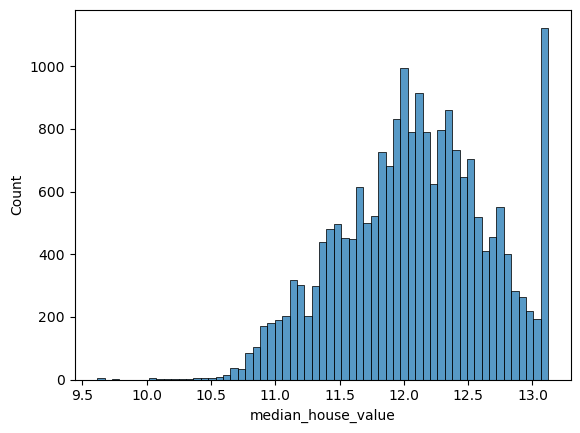

In [216]:
df.median_house_value = np.log1p(df.median_house_value)
sns.histplot(df.median_house_value)

# Prepare dataset

In [217]:
# Test-Train split
df_train_full, df_test = utils.train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = utils.train_test_split(df_train_full, test_size=0.25, random_state=1)

In [218]:
# Prepare dataset for modeling- features and target
df_train_full, y_train_full = utils.dataset_into_features_and_target(df_train_full, 'median_house_value')
df_train, y_train = utils.dataset_into_features_and_target(df_train, 'median_house_value')
df_val, y_val     = utils.dataset_into_features_and_target(df_val, 'median_house_value')
df_test, y_test   = utils.dataset_into_features_and_target(df_test, 'median_house_value')

In [219]:
dv = DictVectorizer(sparse=False)

In [220]:
# Dicts
train_full_dicts = df_train_full.to_dict(orient='records')
train_dicts = df_train.to_dict(orient='records')
val_dicts   = df_val.to_dict(orient='records')
test_dicts = df_test.to_dict(orient='records')

# Apply dv on train dataset
X_train = dv.fit_transform(train_dicts)
X_val   = dv.transform(val_dicts)
X_test  = dv.transform(test_dicts)
X_train_full = dv.transform(train_full_dicts)

***

# Question 1: Which feature is used for splitting the data?


In [221]:
dt = DecisionTreeRegressor(max_depth=1)
dt.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=1)

In [222]:
print(export_text(dt, feature_names=dv.get_feature_names()))

|--- ocean_proximity=INLAND <= 0.50
|   |--- value: [12.31]
|--- ocean_proximity=INLAND >  0.50
|   |--- value: [11.61]



/opt/conda/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


# Question 2: RMSE on validation


In [223]:
rf = RandomForestRegressor(n_estimators=10, 
                           random_state=1,
                           n_jobs=-1)
rf.fit(X_train, y_train)

RandomForestRegressor(n_estimators=10, n_jobs=-1, random_state=1)

In [224]:
y_pred = rf.predict(X_val)

rsme = mean_squared_error(y_val, y_pred, squared=True)
rsme

0.06034889885906303

# Question 3: Plateau for n_estimators

In [225]:
scores = []

for n in range(10, 201, 10):
    rf = RandomForestRegressor(n_estimators=n, 
                               random_state=1,
                               n_jobs=-1)
    rf.fit(X_train, y_train)

    y_pred = rf.predict(X_val)

    rsme = mean_squared_error(y_val, y_pred, squared=True)
    scores.append((n, rsme))
    print(f"n_estimator={n} rsme={rsme}")

    
df_scores = pd.DataFrame(scores, columns=['n_esti','rsme'])
df_scores.head()

n_estimator=10 rsme=0.06034889885906304
n_estimator=20 rsme=0.057040248989584104
n_estimator=30 rsme=0.05538262510618573
n_estimator=40 rsme=0.05487636554867982
n_estimator=50 rsme=0.05428457777999457
n_estimator=60 rsme=0.0541803063738233
n_estimator=70 rsme=0.0539803621595415
n_estimator=80 rsme=0.05401129023211741
n_estimator=90 rsme=0.05387377347510606
n_estimator=100 rsme=0.05379042103472653
n_estimator=110 rsme=0.05358071562691438
n_estimator=120 rsme=0.0536054617793615
n_estimator=130 rsme=0.05365368218968519
n_estimator=140 rsme=0.053641114097496674
n_estimator=150 rsme=0.05364025230479676
n_estimator=160 rsme=0.053610973682736186
n_estimator=170 rsme=0.053560552163084
n_estimator=180 rsme=0.0536540773673145
n_estimator=190 rsme=0.05364804994492544
n_estimator=200 rsme=0.053600178065342195


,n_esti,rsme
0,10,0.060349
1,20,0.057040
2,30,0.055383
3,40,0.054876
4,50,0.054285


<AxesSubplot:xlabel='n_esti', ylabel='rsme'>

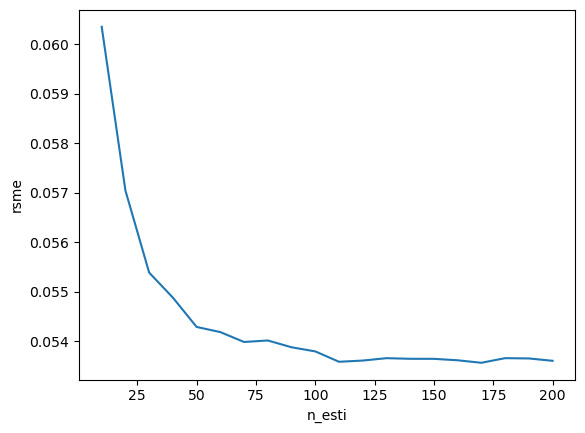

In [226]:
# lineplots of n_esti vs rsme
sns.lineplot(df_scores, x='n_esti', y='rsme')

# Question 4: Best max_depth

In [227]:
!pip install tqdm

In [228]:
from tqdm.auto import tqdm

In [229]:
scores = []

for d in tqdm([10, 15, 20, 25]):
    print('---------------------------------------------')
    print(f"max_depth={d}")
    rf = RandomForestRegressor(max_depth=d, n_estimators=0, 
                               random_state=1,
                               n_jobs=-1)

    for n in range(10, 201, 10):
        rf.n_estimators = n
        
        rf.fit(X_train, y_train)

        y_pred = rf.predict(X_val)

        rsme = mean_squared_error(y_val, y_pred, squared=True)
        scores.append((d, n, rsme))
        #print(f"n_estimator={n} rsme={rsme}")

    
df_scores = pd.DataFrame(scores, columns=['max_depth','n_esti','rsme'])
df_scores.head()

  0%|          | 0/4 [00:00<?, ?it/s]

---------------------------------------------
max_depth=10
---------------------------------------------
max_depth=15
---------------------------------------------
max_depth=20
---------------------------------------------
max_depth=25


,max_depth,n_esti,rsme
0,10,10,0.064821
1,10,20,0.063795
2,10,30,0.063233
3,10,40,0.062960
4,10,50,0.062534


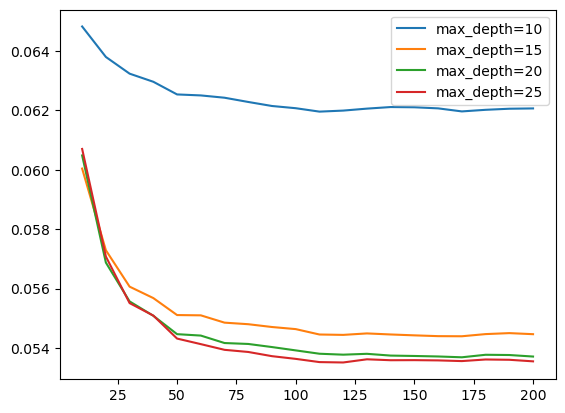

In [230]:
# line plots for max_depts
for d in [10, 15, 20, 25]:
    df_subset = df_scores[df_scores.max_depth == d]
    plt.plot(df_subset.n_esti, df_subset.rsme, label=f"max_depth={d}")
    
plt.legend()

**Answer: 25**

# Question 5: The most important feature

In [231]:
rf = RandomForestRegressor(n_estimators=10, 
                           max_depth=20, 
                           random_state=1, 
                           n_jobs=-1)
rf.fit(X_train, y_train)

RandomForestRegressor(max_depth=20, n_estimators=10, n_jobs=-1, random_state=1)

In [232]:
rf.feature_importances_

array([1.63873827e-02, 3.31454580e-02, 1.01255849e-01, 9.64702137e-02,
       3.63325843e-01, 2.48880276e-03, 3.10900842e-01, 3.56806263e-04,
       4.80369796e-04, 4.69876693e-03, 3.07769212e-02, 1.91716318e-02,
       2.05411131e-02])

In [233]:
df_feature_imp = pd.DataFrame()
df_feature_imp['feature'] = dv.get_feature_names()
df_feature_imp['importance'] = rf.feature_importances_

# Sort by importance
df_feature_imp.sort_values(by='importance', ascending=False)

/opt/conda/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,feature,importance
4,median_income,0.363326
6,ocean_proximity=INLAND,0.310901
2,latitude,0.101256
3,longitude,0.096470
1,housing_median_age,0.033145
10,population,0.030777
12,total_rooms,0.020541
11,total_bedrooms,0.019172
0,households,0.016387
9,ocean_proximity=NEAR_OCEAN,0.004699


# Question 6: Best eta

In [242]:
features = dv.get_feature_names()
dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=features)
dval = xgb.DMatrix(X_val, label=y_val, feature_names=features)

In [243]:
watchlist = [(dtrain, 'train'), (dval, 'val')]

In [257]:
def parse_xgb_ouput(output):
    
    results = []

    for line in output.stdout.strip().split('\n'):

        # split tabs
        num_iter, train, val = line.split('\t')

        # Format 3 values
        num_iter = int(num_iter.strip('[]'))
        train = float(train.strip('train-rsme:'))
        val = float(val.strip('val-rsme:'))

        results.append((num_iter, train, val))

    df_results = pd.DataFrame(results, columns=['n_iter','train', 'val'])

    return df_results

In [258]:
scores = {}

In [265]:
#%%capture output
xgb_params = {
    'eta': 0.1,
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'reg:squarederror',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1,
}


model = xgb.train(xgb_params, dtrain, 
                  num_boost_round=100,
                  verbose_eval=5,
                  evals=watchlist)

[0]	train-rmse:10.44372	val-rmse:10.44938
[5]	train-rmse:6.17513	val-rmse:6.17987
[10]	train-rmse:3.65741	val-rmse:3.66135
[15]	train-rmse:2.17500	val-rmse:2.17928
[20]	train-rmse:1.30499	val-rmse:1.31054
[25]	train-rmse:0.79933	val-rmse:0.80657
[30]	train-rmse:0.51144	val-rmse:0.52189
[35]	train-rmse:0.35700	val-rmse:0.37264
[40]	train-rmse:0.27984	val-rmse:0.30053
[45]	train-rmse:0.24350	val-rmse:0.26829
[50]	train-rmse:0.22614	val-rmse:0.25334
[55]	train-rmse:0.21695	val-rmse:0.24657
[60]	train-rmse:0.21035	val-rmse:0.24189
[65]	train-rmse:0.20579	val-rmse:0.23943
[70]	train-rmse:0.20116	val-rmse:0.23684
[75]	train-rmse:0.19680	val-rmse:0.23507
[80]	train-rmse:0.19384	val-rmse:0.23398
[85]	train-rmse:0.19085	val-rmse:0.23275
[90]	train-rmse:0.18794	val-rmse:0.23206
[95]	train-rmse:0.18541	val-rmse:0.23106
[99]	train-rmse:0.18329	val-rmse:0.23054


(0.22, 0.25)

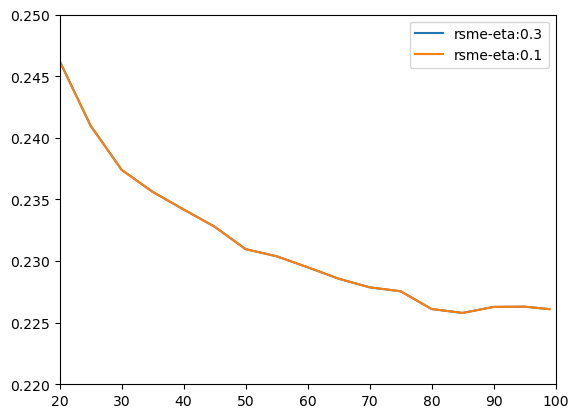

In [269]:
key = f"eta:{xgb_params['eta']}"
scores[key] = parse_xgb_ouput(output)

for key, df_scores in scores.items():
    plt.plot(df_scores.n_iter, df_scores.val, label=f'rsme-{key}')
    
plt.legend()
plt.xlim([20, 100])
plt.ylim([0.22, 0.25])